In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
import re
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [28]:
data = pd.read_csv('data\spam_detection_dataset.csv')
data.head()

,MessageID,Timestamp,Sender,Message,Length,Label
0,1,2023-06-28 07:47:00,Unknown,"Hey, are we still meeting for lunch today?",42,Ham
1,2,2023-11-04 05:37:00,KnownContact,Don't forget the meeting at 10 AM tomorrow.,43,Ham
2,3,2023-06-09 04:58:00,Unknown,URGENT! Your account has been compromised. Ver...,75,Spam
3,4,2023-05-25 18:56:00,KnownContact,"Good night, talk to you tomorrow.",33,Ham
4,5,2023-06-10 12:28:00,Unknown,Let's catch up over coffee this weekend.,40,Ham


In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   MessageID  5000 non-null   int64 
 1   Timestamp  5000 non-null   object
 2   Sender     5000 non-null   object
 3   Message    5000 non-null   object
 4   Length     5000 non-null   int64 
 5   Label      5000 non-null   object
dtypes: int64(2), object(4)
memory usage: 234.5+ KB


In [30]:
data = data.drop(columns=['MessageID'])
data.head()
# data.shape

,Timestamp,Sender,Message,Length,Label
0,2023-06-28 07:47:00,Unknown,"Hey, are we still meeting for lunch today?",42,Ham
1,2023-11-04 05:37:00,KnownContact,Don't forget the meeting at 10 AM tomorrow.,43,Ham
2,2023-06-09 04:58:00,Unknown,URGENT! Your account has been compromised. Ver...,75,Spam
3,2023-05-25 18:56:00,KnownContact,"Good night, talk to you tomorrow.",33,Ham
4,2023-06-10 12:28:00,Unknown,Let's catch up over coffee this weekend.,40,Ham


In [31]:
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data['hour'] = data['Timestamp'].dt.hour
data['DayOfWeek'] = data['Timestamp'].dt.day_of_week
data

,Timestamp,Sender,Message,Length,Label,hour,DayOfWeek
0,2023-06-28 07:47:00,Unknown,"Hey, are we still meeting for lunch today?",42,Ham,7,2
1,2023-11-04 05:37:00,KnownContact,Don't forget the meeting at 10 AM tomorrow.,43,Ham,5,5
2,2023-06-09 04:58:00,Unknown,URGENT! Your account has been compromised. Ver...,75,Spam,4,4
3,2023-05-25 18:56:00,KnownContact,"Good night, talk to you tomorrow.",33,Ham,18,3
4,2023-06-10 12:28:00,Unknown,Let's catch up over coffee this weekend.,40,Ham,12,5
...,...,...,...,...,...,...,...
4995,2023-09-17 01:33:00,KnownContact,"Hey, are we still meeting for lunch today?",42,Ham,1,6
4996,2023-05-29 13:51:00,Unknown,URGENT! Your account has been compromised. Ver...,75,Spam,13,0
4997,2023-10-14 12:36:00,Unknown,Are you coming to the party tonight?,36,Ham,12,5
4998,2023-05-19 13:59:00,Unknown,Let's catch up over coffee this weekend.,40,Ham,13,4


Label
Ham     3997
Spam    1003
Name: count, dtype: int64

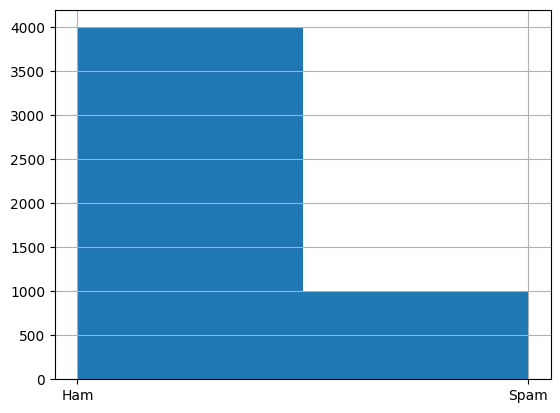

In [32]:
plt.hist(data['Label'],bins=2)
plt.grid(True)
data['Label'].value_counts()

In [33]:
data = data.drop(columns=['Timestamp'])
data.head()

,Sender,Message,Length,Label,hour,DayOfWeek
0,Unknown,"Hey, are we still meeting for lunch today?",42,Ham,7,2
1,KnownContact,Don't forget the meeting at 10 AM tomorrow.,43,Ham,5,5
2,Unknown,URGENT! Your account has been compromised. Ver...,75,Spam,4,4
3,KnownContact,"Good night, talk to you tomorrow.",33,Ham,18,3
4,Unknown,Let's catch up over coffee this weekend.,40,Ham,12,5


In [34]:
# encode_label = pd.get_dummies(data['Label']) # this is y label
# encode_label.head()
label_encoder = LabelEncoder()
y_label = label_encoder.fit_transform(data['Label'])
y_label

array([0, 0, 1, ..., 0, 0, 0])

In [35]:
def clean_text(text):
    text = text.lower()                         # make lowercase
    text = re.sub(r'http\S+|www\S+', '', text)  #  remove URLs
    text = re.sub(r'[^a-z\s]', '', text)        # remove punctuation, numbers, emojis
    text = re.sub(r'\s+', ' ', text).strip()    # remove extra spaces
    return text

In [36]:
data['Cleaned_message'] = data['Message'].apply(clean_text)
data = data.drop(columns=['Message'])
data.head()

,Sender,Length,Label,hour,DayOfWeek,Cleaned_message
0,Unknown,42,Ham,7,2,hey are we still meeting for lunch today
1,KnownContact,43,Ham,5,5,dont forget the meeting at am tomorrow
2,Unknown,75,Spam,4,4,urgent your account has been compromised verif...
3,KnownContact,33,Ham,18,3,good night talk to you tomorrow
4,Unknown,40,Ham,12,5,lets catch up over coffee this weekend


In [37]:
Message_vectorizer = CountVectorizer()
sender_vectorizer = CountVectorizer()

x_message = Message_vectorizer.fit_transform(data['Cleaned_message'])
x_sender = sender_vectorizer.fit_transform(data['Sender'])

In [38]:
data.head()

,Sender,Length,Label,hour,DayOfWeek,Cleaned_message
0,Unknown,42,Ham,7,2,hey are we still meeting for lunch today
1,KnownContact,43,Ham,5,5,dont forget the meeting at am tomorrow
2,Unknown,75,Spam,4,4,urgent your account has been compromised verif...
3,KnownContact,33,Ham,18,3,good night talk to you tomorrow
4,Unknown,40,Ham,12,5,lets catch up over coffee this weekend


In [39]:
scaler = MinMaxScaler()
scaled_leangth = scaler.fit_transform(data[['Length']])
scaled_leangth

array([[0.29787234],
       [0.31914894],
       [1.        ],
       ...,
       [0.17021277],
       [0.25531915],
       [0.53191489]])

In [40]:
X =  hstack([x_sender,
             x_message,
             data['hour'].values.reshape(-1, 1),
             data['DayOfWeek'].values.reshape(-1, 1),
             scaled_leangth
             ])
y = y_label

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [42]:
# X_train_dense = X_train.toarray()  # if sparse matrix
# X_test_dense = X_test.toarray()

In [43]:
# scaler = MinMaxScaler()
# scaler.fit(X_train_dense)
# X_train_scaled = scaler.transform(X_train_dense)
# X_test_scaled = scaler.transform(X_test_dense)

In [44]:
from sklearn.svm import SVC
svm_model = SVC(kernel='poly', C=1.0, gamma='scale')  # Try 'linear', 'poly', or 'sigmoid' too
svm_model.fit(X_train, y_train)
y_pred_mnb = svm_model.predict(X_test)

In [45]:
# mnb = MultinomialNB()
# mnb.fit(X_train, y_train)
# y_pred_mnb = mnb.predict(X_test)
# y_pred_mnb

In [46]:
print(f"Accuracy: {accuracy_score(y_test, y_pred_mnb)}")
print(f"Precision: {precision_score(y_test, y_pred_mnb)}")
print(f"Recall: {recall_score(y_test, y_pred_mnb)}")
print(f"F1-Score: {f1_score(y_test, y_pred_mnb)}")

Accuracy: 0.938
Precision: 1.0
Recall: 0.6847457627118644
F1-Score: 0.8128772635814889


In [47]:
y_pred_train = svm_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"\nTraining accuracy: {train_accuracy}")
print(f"Test accuracy: {accuracy_score(y_test, y_pred_mnb)}")


Training accuracy: 0.9257142857142857
Test accuracy: 0.938


In [48]:
y_test

array([1, 1, 0, ..., 0, 0, 0])

In [49]:
y_pred_mnb

array([1, 0, 0, ..., 0, 0, 0])

In [50]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, y_pred_mnb))

[[1205    0]
 [  93  202]]


In [51]:
import joblib

joblib.dump(svm_model, 'model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoder, 'encoders.pkl')

['encoders.pkl']